# Recreating Results from Heneka et al. 2017

### Tyler Cox

This notebook has been created to recreate the results from [Heneka et. al 2017](https://arxiv.org/pdf/1611.09682.pdf). In this paper, authors showed how cross-correlation of cosmological Ly$\alpha$ and 21cm emission could potential be used as a probe of reionization. In their analysis, they used simulated Ly$\alpha$ and 21cm data created by 21cmFAST along with instrument effects from Ly$\alpha$ probes (SPHEREx and CDIM) and a 21cm probe (SKA Low). I will use their process to simulate SPHEREx and HERA cross-correlation.

## 21cmFAST

Parameters:

$w = -1$, $\Omega_m = 0.32$, $\Omega_K = 0$, $\Omega_b = 0.049$,

$h = 0.67$, $\sigma_8 = 0.83$, $n_s = 0.96$, $\Omega_r = 8.6 \times 10^{-5}$,

$N_{eff} = 3.046$, $Y_{He} = 0.24$, $R_{mfp}^{UV} = 40$ Mpc, $T_{vir} = 10^4 K$

$\zeta_x = 10^{56}$, $f_* = 0.1$, $\zeta = 10$

Box Size: 200 Mpc $\times$ 200 Mpc

In [4]:
import sys
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
from powerbox.powerbox import get_power
from scipy.ndimage.filters import gaussian_filter

plt.rc('font', family='serif')

cmap = matplotlib.cm.inferno
cmap.set_bad('black',1.)

Loading the data

In [5]:
def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.frombuffer(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

## Helpful Functions

In [6]:
def H(z):
    '''
    Returns astropy Hubble constant at given redshift
    
    Units: km Mpc^-1 s^-1
    '''
    return cosmo.H(z)

def y(z):
    '''
    wl_lya -> Lyman-alpha wavelength in units of km
    
    Returns value in units of Mpc s
    '''
    l_lya = 2.46e-15 * u.m 
    return l_lya * (1.0 + z) ** 2 / H(z)

In [7]:
def star_formation_rate(M, z = 7, sim_num = 1):
    '''
    Returns the star-formation rate for a dark-matter halo of a given mass and redshift
    
    Units: M_sun per year
    
    
    Note: Zero-out redshift for now. Other versions of this equation use redshift but the current
          sim that I am basing this equation off of does not use redshift.
    
    https://arxiv.org/pdf/1205.1493.pdf
    
    '''

    if sim_num == 1:
        a, b, d, c1, c2 = 2.8, -0.94, -1.7, 1e9, 7e10
        sfr = 2.8e-28 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d
        
    if sim_num == 2:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 1.6e-26 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
        
    if sim_num == 3:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 2.25e-26 * (1.0 + 0.075 * (z-7)) * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
    
    return sfr * u.M_sun / u.year

In [8]:
star_formation_rate(1e11)

<Quantity 5.10504344 solMass / yr>

In [9]:
def f_lya(z, C_dust = 3.34, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    '''
    return C_dust * 1e-3 * (1.0 + z) ** zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    def alpha(z):
        '''
        Alpha/beta values found in:

        https://arxiv.org/pdf/0903.2045.pdf
        '''
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        a = np.array([2.78e-2, 1.30e-2, 5.18e-3, 3.42e-3, 6.68e-5, 4.44e-5])
        b = np.array([0.105, 0.179, 0.244, 0.262, 0.431, 0.454])
        fa = interp1d(zs, a, kind = 'cubic')
        fb = interp1d(zs, b, kind = 'cubic')
        return (fa(z), fb(z))
    
    a, b = alpha(z)
    return np.exp(-a * M ** b)

# Relevant Equations

## Galactic Component

### Simulating Ly$\alpha$ Emission

$$f_{Ly\alpha}(z)=C_{dust}10^{−3}\left(1+z\right)^{\zeta}$$

$C_{dust} = 3.34$

$\zeta = 2.57$

$$f_{esc}(z) = $$

### Ly${\alpha}$ Luminosity from Excitations of the Interstellar Medium

$$L_{exc}^{gal} = f_{Ly\alpha} \left(1-f_{esc}\right) A_{He} E_{exc} \dot{N}_{ion}$$

$$\dot{N}_{ion} = Q_{ion} \times \text{SFR}$$

$Q_{ion} = 5.38 \times 10^{60} \text{\(M_\odot\)}^{-1}$  is obtained from: http://iopscience.iop.org/article/10.1088/0004-637X/763/2/132/pdf


### Ly$\alpha$ Luminosity from Recombination

$$L_{rec}^{gal} = A_{He} f_{rec} f_{Ly\alpha} \left(1-f_{esc}\right) E_{Ly\alpha} \dot{N}_{ion}$$

Still not sure about this relationship:

$$f_{rec} \approx 0.66$$

### Total Galactic Ly$\alpha$ Luminosity

$$L^{gal} \left(M,z\right) = L_{rec}^{gal}\left(M,z\right) + L_{exc}^{gal}\left(M,z\right)$$


### Luminosity to Surface Brightness

$$L^{gal} \left(\textbf{x},z\right) = y \left( z \right ) d_A^2 \left( z \right ) \frac{L^{gal} \left(\textbf{x},z\right)}{4 \pi d_L^2 \left( z \right )}$$

Supposedly,

$$d_L\left( z \right ) = \left(1+z \right)^2 d_A \left( z \right )$$

And,

$$ y \left( z \right ) = \lambda_0 \frac{\left(1+z \right)^2}{H \left( z \right )}$$

So,

$$I_{\nu}^{gal} \left(\textbf{x},z\right) = \frac{\lambda_0  L^{gal} \left(\textbf{x},z\right)}{4 \pi \left(1+z \right)^2 H \left( z \right )}$$

In [10]:
def L_gal_exc(M, z):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_v in ergs
    
    '''
    Y_He = 0.245
    A_He = (4.0 - Y_He)/(4.0 - 3*Y_He)
    Q_ion = 5.38e60 * u.M_sun ** -1
    Ev = 21.4 * u.eV
    E_exc = Ev * 0.1
    
    return (f_lya(z) * (1.0 - f_esc(M,z)) * A_He * E_exc * 
            Q_ion * star_formation_rate(M, z = z))

def L_gal_rec(M, z, f_rec = 0.66):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_lya units in ergs
    
    Return Units: ergs/year
    '''
    Q_ion = 5.38e60 * u.M_sun ** -1
    Y_He = 0.245
    E_lya = 1.637e-11 * u.erg
    A_He = (4.0 - Y_He)/(4.0 - 3.0 * Y_He)
    
    return (A_He * f_rec * f_lya(z) * (1.0 - f_esc(M,z)) * E_lya * 
            Q_ion * star_formation_rate(M, z = z))

def L_gal(M, z):
    '''
    Total galactic lya luminosity. Pass in output from L_rec and L_exc, which are in units of ergs/year
    '''
    return (L_gal_exc(M, z) + L_gal_rec(M, z)).to(u.erg * u.second ** -1)

def I_gal(M, z, v = (200. / 256 * u.Mpc) ** 3):
    """Surface brightness of Lyman-alpha
    """
    v = (10 * u.kpc) ** 3
    l_gal = L_gal(M, z = 7) / v
    return (l_gal * y(z) * (cosmo.comoving_transverse_distance(z) ** 2 / 
                          (4 * np.pi * cosmo.lookback_distance(z) ** 2))).to(u.erg * u.cm ** -2)


def _I_gal(M, z, v = (200. / 256 * u.Mpc) ** 3):
    """Surface brightness of Lyman-alpha
    """
    l_gal = L_gal(M, z = 7) / v
    return (l_gal * y(z) * (cosmo.angular_diameter_distance(z) ** 2 / 
                          (4 * np.pi * cosmo.luminosity_distance(z) ** 2))).to(u.erg * u.cm ** -2)

nu_lya = 2.47e15 * u.second ** -1

In [11]:
zs = [6.00, 7.04, 8.06, 10.00]
halo_files = glob.glob('../../data/halos*')
halo_files = [f for f in halo_files for z in zs if str(z) in f]

In [73]:
z = 10.04
halos = np.genfromtxt('../../data/halos_z10.04_768_200Mpc')

In [74]:
halo_pos = (halos[:, 1:] * 256).astype(int)
halo_mass = halos[:, 0]
idx = np.where(halo_pos[:, 2] == 127)[0]

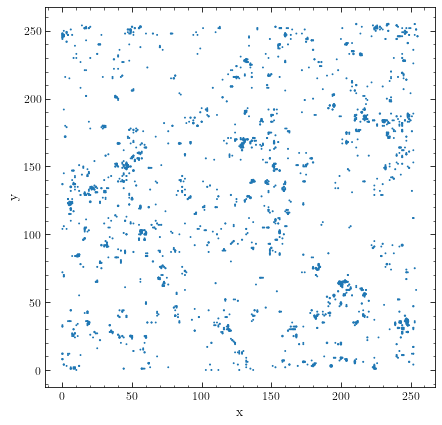

In [75]:
plt.figure(figsize=(7,7))
plt.scatter(halo_pos[idx, 1], halo_pos[idx, 0], s = 10 * halo_mass / halo_mass.max())
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [86]:
def cube_3d(z):
    lya_field = np.zeros((256, 256, 256))
    sb_lya = (nu_lya / (z + 1) * I_gal(halo_mass, z = z)).value

    for i in np.arange(halo_pos[:, :].shape[0]):
        lya_field[halo_pos[:, 1][i], halo_pos[:, 0][i], halo_pos[:, 2][i]] += sb_lya[i]
    return lya_field

In [87]:
k_bins = 14

In [88]:
lya_cube = cube_3d(z)

In [85]:
lya_cube.mean()

7.142571726480977e-20

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


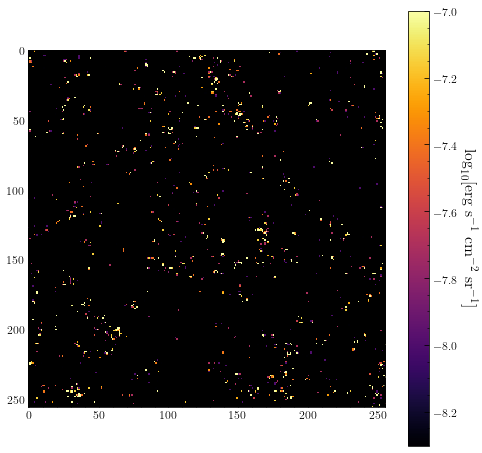

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(lya_cube[:, :, 127]), cmap = 'inferno', vmax = -7)
cbar = plt.colorbar()
cbar.set_label(r'$\log_{10} [\rm erg \ s^{-1} \ cm^{-2} \ sr^{-1}]$', rotation=270, labelpad = 18, fontsize = 16)
plt.show()

In [80]:
ps_Lya, k_Lya, var = get_power(lya_cube / 3e-10 - 1, 200, bins = k_bins, log_bins = True, 
                               dimensionless = False, get_variance=True)

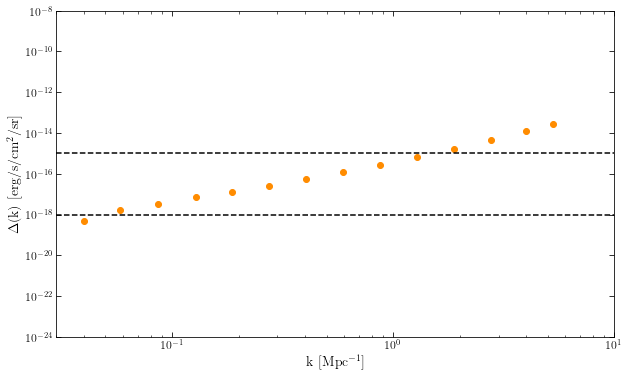

In [81]:
plt.figure(figsize = (10,6))
plt.scatter(k_Lya, (3e-10) ** 2 * ps_Lya * k_Lya ** 3 / (2 * np.pi ** 2), color = 'darkorange')
plt.ylim([1e-24, 1e-8])
plt.xlim([3e-2, 10])
plt.axhline(1e-15, color = 'k', linestyle = '--')
plt.axhline(1e-18, color = 'k', linestyle = '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta ({\rm k})$ [erg/s/cm$^2$/sr]')
plt.show()

In [89]:
T_21 = load_binary_data('../../data/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc')
T_21 = T_21.reshape((256,256,256))

In [104]:
def rayleigh(T, z):
    T *= u.mK
    nu = 1420 / (1 + z) * u.MHz
    return nu * 2 * const.h * nu ** 3 / (const.c ** 2) * (np.exp(const.h * nu / (const.k_B * T)) - 1.0) ** -1

In [105]:
I_21 = rayleigh(T_21, 7.04)
I_21 = I_21.to(u.erg / u.s / u.cm ** 2)

In [109]:
get_power?

In [107]:
ps_21_SI, k_21 = get_power(I_21.value, 200, log_bins = True, bins = k_bins)
ps_21, k_21 = get_power(T_21, 200, log_bins = True, bins = k_bins)

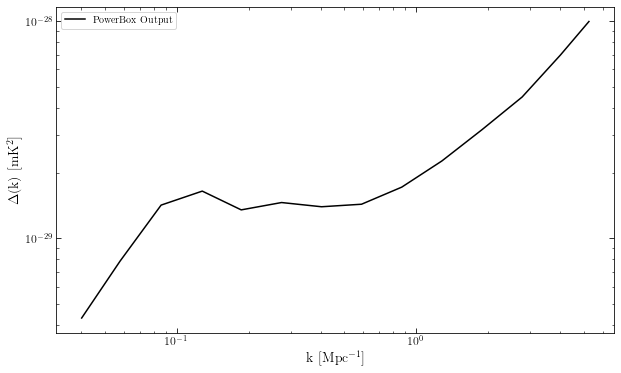

In [108]:
plt.figure(figsize = (10,6))
plt.plot(k_21, ps_21_SI * k_21 ** 3 / (2 * np.pi ** 2), color = 'k', label = 'PowerBox Output')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta ({\rm k})$ [mK$^2$]')
plt.legend()
plt.show()

In [207]:
x_power, k = get_power(lya_cube, 200, deltax2 = I_21.value,log_bins = True, bins = k_bins)
ps_21_SI, _ = get_power(I_21.value, 200, log_bins = True, bins = k_bins)

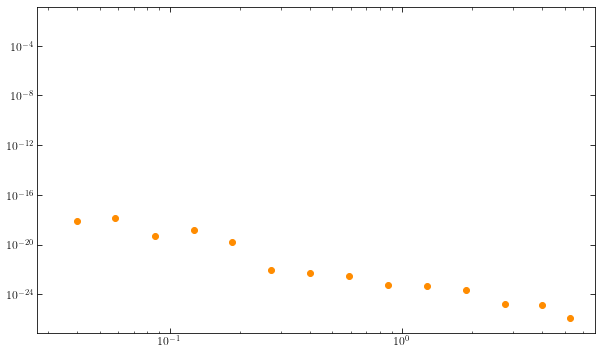

In [208]:
plt.figure(figsize=(10,6))
plt.scatter(k, np.abs(x_power), color = 'darkorange')
plt.plot(k, np.abs(x_power), alpha = 0)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [232]:
heneka = np.genfromtxt('data.csv', delimiter=',')

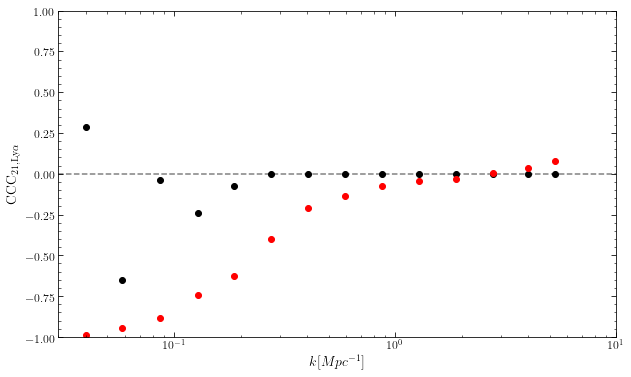

In [236]:
plt.figure(figsize = (10,6))
plt.scatter(k, x_power / np.sqrt(ps_21_SI * ps_Lya), color = 'black')
plt.scatter(k, heneka[::-1, 1], color = 'red')
plt.xscale('log')
plt.xlabel(r'$k [Mpc^{-1}]$', fontsize = 14)
plt.ylabel(r'CCC$_{\rm 21, Ly\alpha}$', fontsize = 14)
plt.ylim([-1, 1])
plt.xlim([3e-2, 10])
plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.5, zorder = 0)
plt.show()

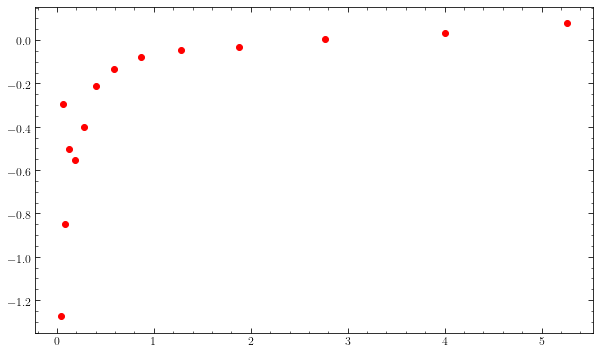

In [239]:
plt.figure(figsize=(10,6))
plt.scatter(k, heneka[::-1, 1] - x_power / np.sqrt(ps_21_SI * ps_Lya), color = 'red')
plt.show()

## Diffuse IGM

In [152]:
xi = load_binary_data('/data4/tcox/21cmFAST/Boxes/Nrec_z007.04_HIIfilter1_RHIImax50_256_200Mpc')

def alpha_A(Tk, z):
    return 4.2e-13 * (Tk / 1e4) ** -0.7 * (1 + z) ** 3 * u.cm ** 3 / u.s

def n_dot_rec(z):
    return alpha_A(Tk, z) * n_e(z) * n_HII(z)

def n_b(d_nl, z):
    return (1.905e-7 / u.cm ** 3) * (1 + z) ** 3 * (1 + d_nl)

def n_e(d_nl, z):
    return xi * n_b(d_nl, z)

def n_HII(z):
    Ye = 0.24
    return xi * n_b(d_nl, z) * (4 - 4 * Ye) / (4 - 3 * Ye)

In [185]:
xi = load_binary_data('/data4/tcox/21cmFAST/Boxes/Nrec_z007.04_HIIfilter1_RHIImax50_256_200Mpc') / u.second

In [186]:
xi_box = xi.reshape((256,256,256))

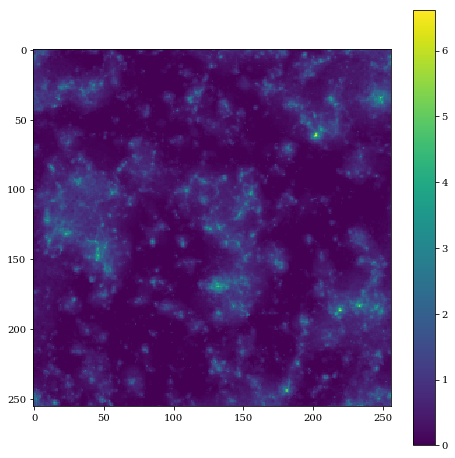

In [187]:
plt.figure(figsize=(8,8))
plt.imshow(xi_box[:, :, 127].value)
plt.colorbar()
plt.show()